2500 iterations elapsed
5000 iterations elapsed
7500 iterations elapsed
10000 iterations elapsed
chain 1 done
2500 iterations elapsed
5000 iterations elapsed
7500 iterations elapsed
10000 iterations elapsed
chain 2 done
2500 iterations elapsed
5000 iterations elapsed
7500 iterations elapsed
10000 iterations elapsed
chain 3 done
2500 iterations elapsed
5000 iterations elapsed
7500 iterations elapsed
10000 iterations elapsed
chain 4 done
Accepted Parameter Sets for Chain 1: 16 out of 10000

Accepted Parameter Sets for Chain 2: 17 out of 10000

Accepted Parameter Sets for Chain 3: 1 out of 10000

Accepted Parameter Sets for Chain 4: 16 out of 10000



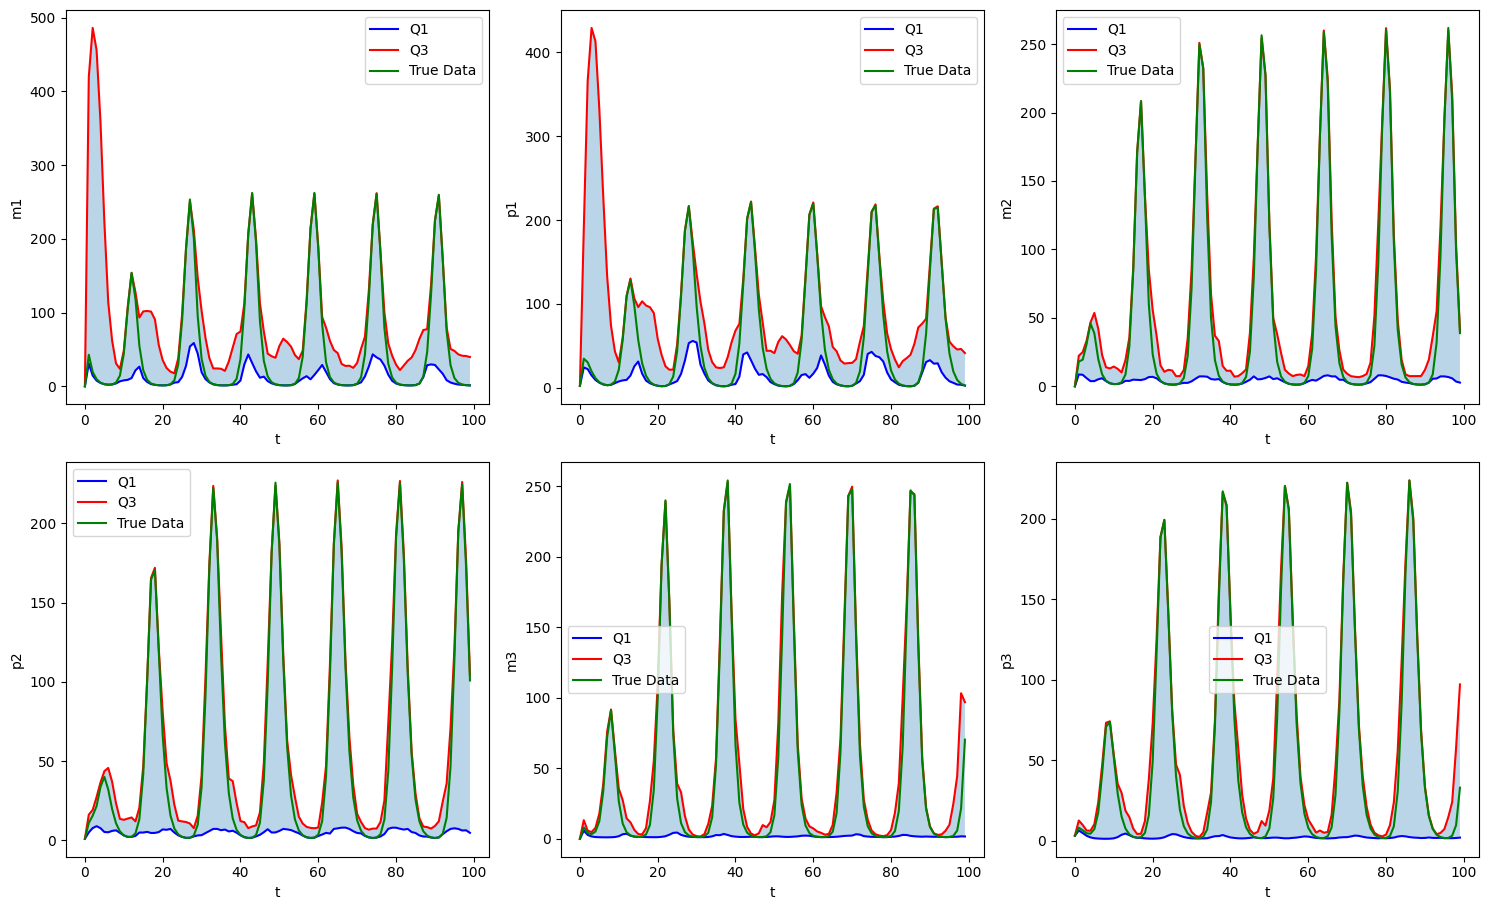

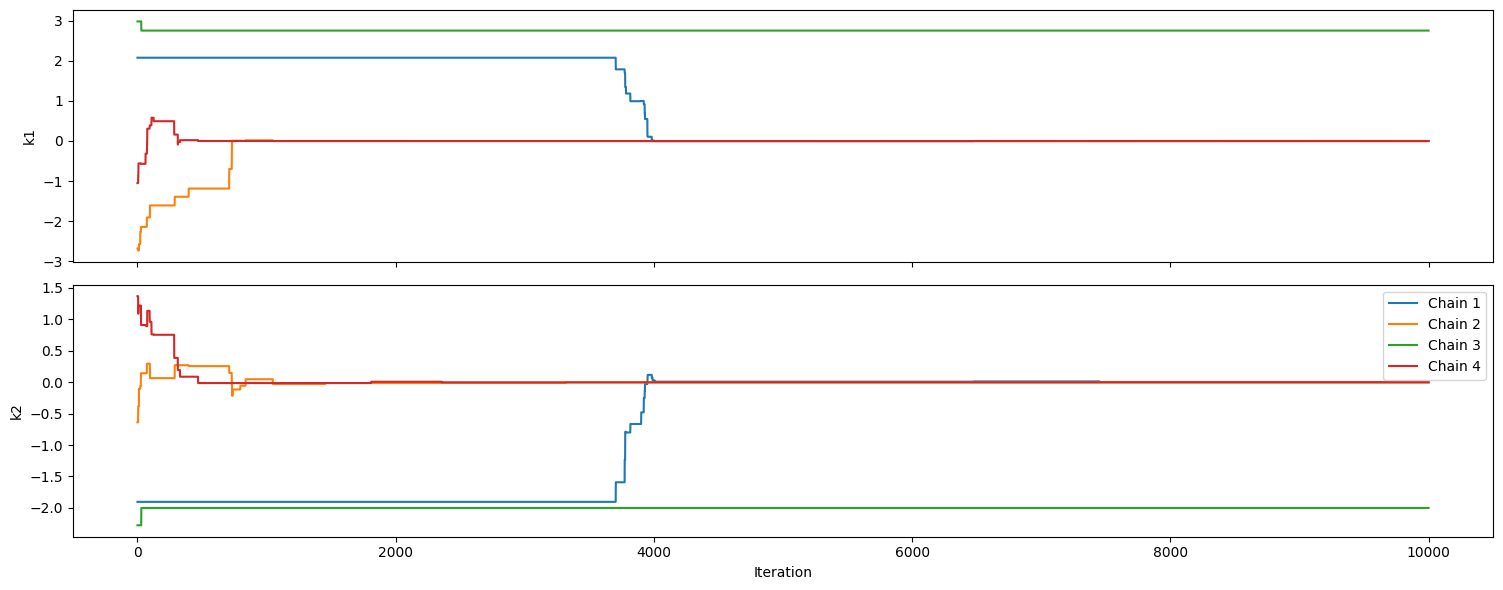

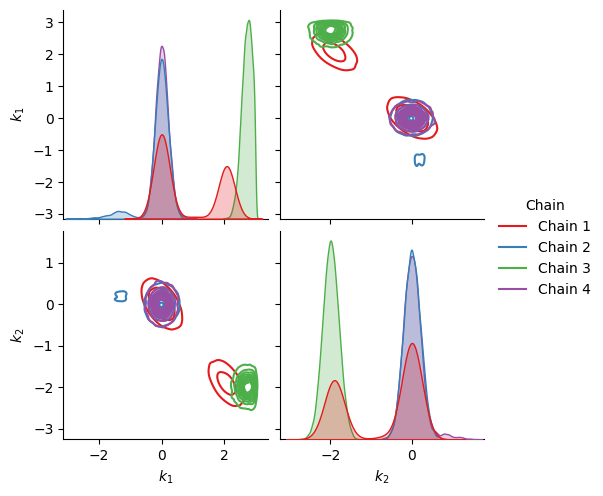

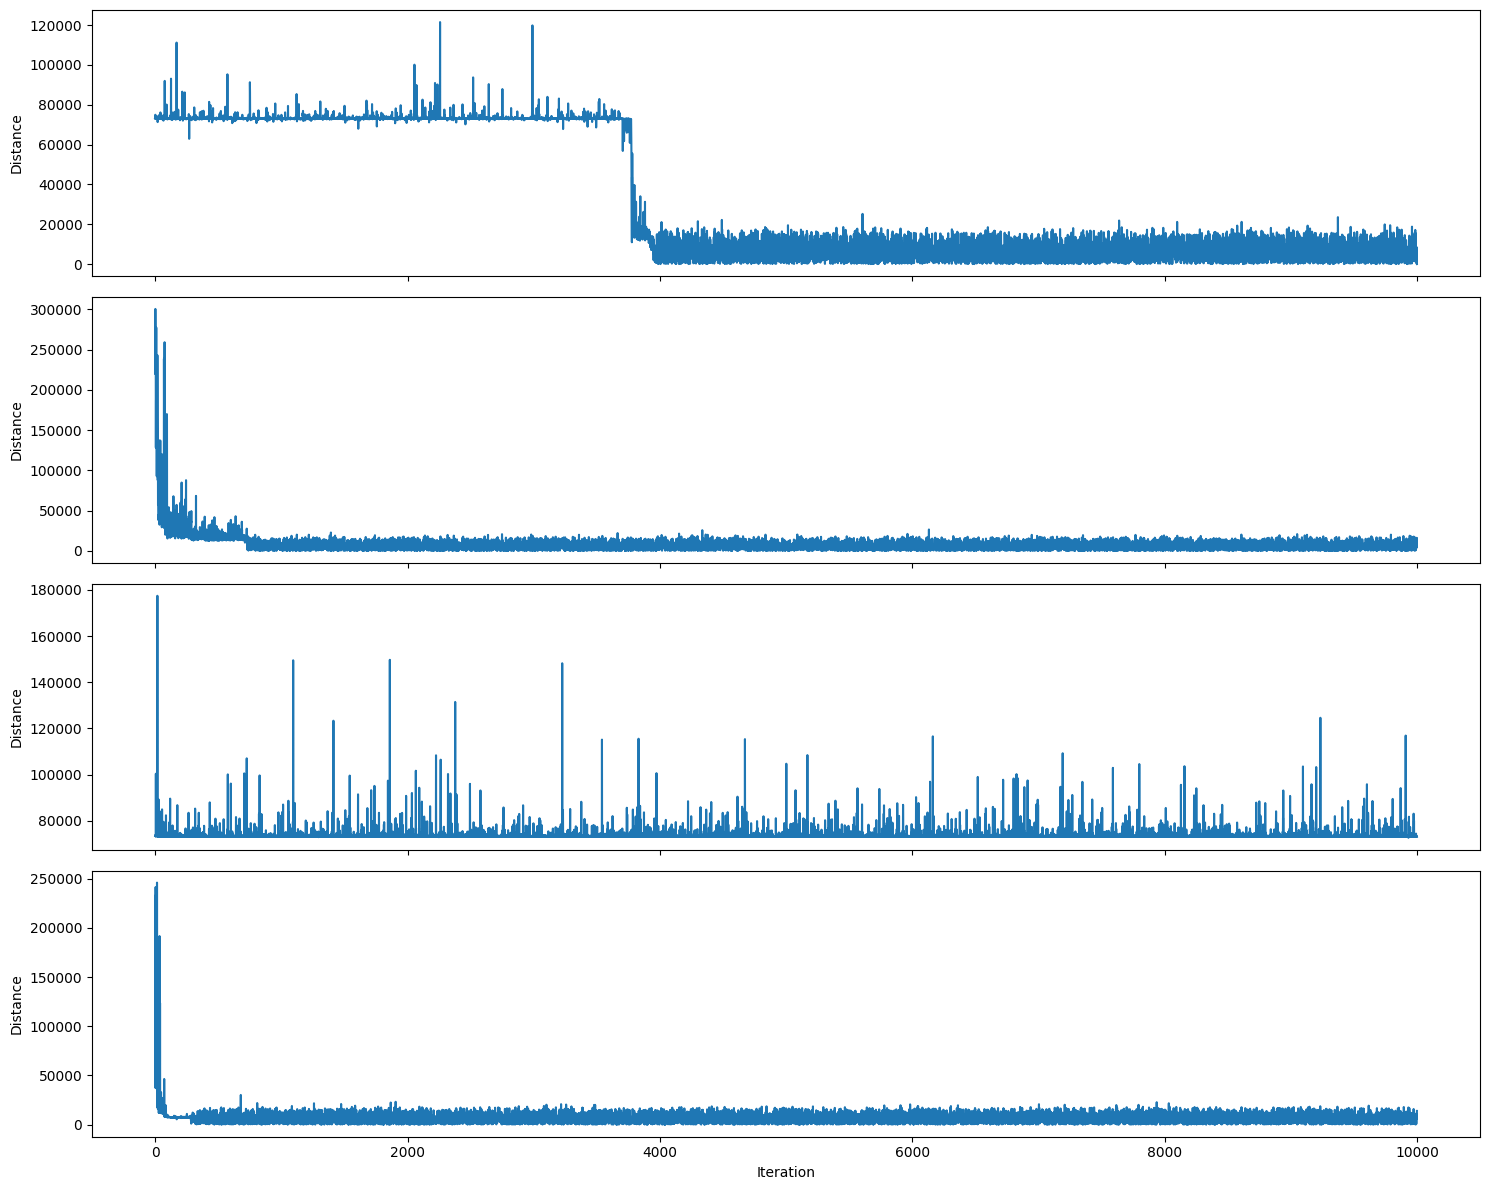

In [1]:
############### CLASSICAL MCMC ################## using Toni et al., 2008 ["Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems"]

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import math

warnings.filterwarnings("ignore", category=RuntimeWarning)

num_timesteps = 100
headers = ['k1', 'k2']

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2)**2)) + 10 ** 0
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3)**2)) + 10 ** 0
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1)**2)) + 10 ** 0
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_parameters = np.array([0, 0])

def solve_ode(params, t):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        initial_conditions = np.array([0, 2, 0, 1, 0, 3])
        solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

t = np.linspace(0, 100, num_timesteps)
true_solutions = solve_ode(true_parameters, t) # used in MCMC
true_data=np.array(true_solutions) # used to plot

#---------------------------------------------------------

def get_distance(truth, simulation):
    truth = np.array(truth)
    simulation = np.array(simulation)

    if truth.shape != simulation.shape:
        raise ValueError("Input arrays must have the same shape")

    squared_differences = np.square(truth - simulation)
    mean_squared_difference = np.mean(squared_differences)

    return mean_squared_difference

#--------------------------------------------------------------------------------

def abc_mcmc_multiple_chains(true_params, num_iterations, num_chains=4):
    all_params = []
    all_accepted_data = []
    all_parameter_traces = []
    all_accepted_counts = []
    all_distances = []
    all_stored_accepted_data = []

    for chain in range(num_chains):
        stored_accepted_data =[]
        params = []
        distances = []
        accepted_data = []
        current_params = np.random.uniform(low=-3, high=3, size=len(true_params))
        parameter_traces = [current_params.copy()]  # Collect parameter traces to plot
        accepted_count = 0

        for _ in range(1, num_iterations+1):
            proposal_scale = 0.2
            while True:
                proposed_params = current_params + np.random.normal(scale=proposal_scale, size=len(current_params))
                if max(proposed_params) > 3 or min(proposed_params) < -3:
                    continue  # repeat the current iteration
                break  # exit the while loop if conditions are satisfied
            proposed_simulation = solve_ode(proposed_params, t)
            params.append(proposed_params)

            if len(accepted_data) != 0: #if the list is empty
                current_simulation = accepted_data
            else:
                current_simulation = solve_ode(current_params, t)
            
            p_proposed = get_distance(true_solutions, proposed_simulation)
            distances.append(p_proposed)

            p_current = get_distance(true_solutions, current_simulation)
            acceptance_prob = min(1, math.log(p_current/p_proposed))
                        
            if np.random.rand() < acceptance_prob:
                current_params = proposed_params
                accepted_count += 1
                accepted_data = proposed_simulation
                stored_accepted_data.append(accepted_data)
                
            # Collect parameter traces
            parameter_traces.append(current_params.copy())
            if _ %2500 == 0 and _ !=0:
                print(f"{_} iterations elapsed")

        print(f"chain {chain+1} done")
        # Store results for the current chain
        all_distances.append(distances)
        all_params.append(np.array(params))
        all_stored_accepted_data.append(np.array(stored_accepted_data)) 
        all_parameter_traces.append(np.array(parameter_traces))
        all_accepted_counts.append(accepted_count)

    return all_params, all_stored_accepted_data, all_parameter_traces, all_accepted_counts, all_distances

#---------------------------------------------------------

# ABC MCMC
num_iterations = 10000 # in each chain
num_chains = 4

all_accepted_parameters, all_accepted_data, all_parameter_traces, all_accepted_counts, all_distances = abc_mcmc_multiple_chains(true_parameters, num_iterations, num_chains)

burn_in_fraction = 0.3
burn_in_iterations = int(num_iterations * burn_in_fraction)

#---------------------------------------------------------

# Table of accepted parameter sets

for chain, (accepted_params, accepted_count) in enumerate(zip(all_accepted_parameters, all_accepted_counts)):
    print(f"Accepted Parameter Sets for Chain {chain + 1}: {accepted_count} out of {num_iterations}\n")


##################################################################### TRAJECTORIES ##################################
variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']

# Initialize lists to store quartiles for each variable
quartiles = [[] for _ in range(len(variables))]

# Iterate over each variable
for variable_idx in range(len(variables)):
    variable_list = []
    # Iterate over each timestep
    for timestep in range(num_timesteps):
        timestep_list = []
        # Iterate over each chain and simulation
        for chain in all_accepted_data:
            for simulation in chain:
                timestep_list.append(simulation[timestep][variable_idx])
        variable_list.append(timestep_list)

    # Calculate quartiles for the current variable
    q1_list = []
    q3_list = []
    for timestep_data in variable_list:
        q3, q1 = np.percentile(timestep_data, [75, 25])
        q1_list.append(q1)
        q3_list.append(q3)

    # Append quartile lists for the current variable
    quartiles[variable_idx].extend([q1_list, q3_list])

# Output quartiles for each variable
for idx, variable in enumerate(variables):
    q1_list = quartiles[idx][0]
    q3_list = quartiles[idx][1]


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, ax in enumerate(axes.flat):
    q1_list = quartiles[idx][0]
    q3_list = quartiles[idx][1]
    true_variable_data = true_data[:, idx]  # Extract true data for the current variable
    ax.plot(range(num_timesteps), q1_list, label='Q1', color='blue')
    ax.plot(range(num_timesteps), q3_list, label='Q3', color='red')
    ax.fill_between(range(num_timesteps), q1_list, q3_list, alpha=0.3)
    ax.plot(range(num_timesteps), true_variable_data, label='True Data', color='green')
    ax.set_xlabel('t')
    ax.set_ylabel(variables[idx])
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

############################################ PARAMETER TRACES ########################################

fig, axs = plt.subplots(len(true_parameters), 1, figsize=(15, 3 * len(true_parameters)), sharex=True)

for i in range(len(true_parameters)):
    for chain in range(num_chains):
        axs[i].plot(all_parameter_traces[chain][:, i], alpha=1, label=f"Chain {chain+1}")
    
    axs[i].set_ylabel(headers[i])

axs[-1].set_xlabel('Iteration')
plt.legend()
plt.tight_layout()
plt.show()

####################################################### PAIRPLOTS ###################################
k1_accept = []
k2_accept = []
chain_labels = []

for chain in range(num_chains):
    for i in range(len(all_accepted_parameters[chain])):
        k1_accept.append(all_accepted_parameters[chain][i][0])
        k2_accept.append(all_accepted_parameters[chain][i][1])
        chain_labels.append(f"Chain {chain + 1}")

plot_data = pd.DataFrame({
    r"$k_{1}$": k1_accept,
    r"$k_{2}$": k2_accept,
    "Chain": chain_labels})

plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plot using seaborn's pairplot with KDE
sns.pairplot(plot_data, kind="kde", hue="Chain", palette="Set1")

############################################################# DISTANCES OVER ITERATION ##############################

fig, axs = plt.subplots(num_chains, 1, figsize=(15, 3 * num_chains), sharex=True)

for chain in range(num_chains):
    axs[chain].plot(all_distances[chain], label=f"Chain {chain+1}")
    axs[chain].set_ylabel('Distance')

axs[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()



In [ ]:
# Plot simulations
variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot true data
for i, variable in enumerate(variables):
    row, col = divmod(i, 2)
    axs[row, col].plot(t, true_data[:, i], label='True Data', linewidth=2)
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel(variables[i])

# Plot simulations from all chains
for chain in range(num_chains):
    for param in range(len(all_accepted_data[chain])):
        simulation = all_accepted_data[chain][param]
        for i, variable in enumerate(variables):
            row, col = divmod(i, 2)
            axs[row, col].plot(t, simulation[:, i], label=f'Chain {chain + 1}', alpha=0.01)
            axs[row, col].legend()

plt.tight_layout()
plt.show()

In [11]:
############### SAMPLE-ADAPTIVE MCMC ################## using Zhu, 2019 ["Sample Adaptive MCMC"]

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

num_timesteps = 100
headers = ['k1', 'k2']

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2)**2)) + 10 ** 0
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3)**2)) + 10 ** 0
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1)**2)) + 10 ** 0
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_parameters = np.array([0, 0])

def solve_ode(params, t):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        initial_conditions = np.array([0, 2, 0, 1, 0, 3])
        solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

t = np.linspace(0, 100, num_timesteps)
true_solutions = solve_ode(true_parameters, t) # used in MCMC
true_data=np.array(true_solutions) # used to plot

#---------------------------------------------------------

def get_distance(truth, simulation):
    truth = np.array(truth)
    simulation = np.array(simulation)

    if truth.shape != simulation.shape:
        raise ValueError("Input arrays must have the same shape")

    squared_differences = np.square(truth - simulation)
    mean_squared_difference = np.mean(squared_differences)

    return mean_squared_difference

#--------------------------------------------------------------------------------

def abc_sa_mcmc_multiple_chains(true_params, num_iterations, num_chains, kernel_factor):
    all_params = []
    all_parameter_traces = []

    for chain in range(num_chains):
        params = []
        current_params = np.random.uniform(low=-3, high=3, size=len(true_params)) # prior
        parameter_traces = [current_params.copy()]  # Collect parameter traces to plot
        c_distance = None
       
        for _ in range(1, num_iterations+1):
           
            if c_distance == None:
                current_simulation = solve_ode(current_params,t)
                c_distance = 1/get_distance(true_solutions, current_simulation)
            
            loc = np.mean(current_params, axis=0)
            scale = np.cov(np.array(current_params).T, rowvar=False)
            new_param = np.random.normal(loc=loc, scale=(2.0 * kernel_factor * scale))
            proposals=[]
            likelihoods = []
        
            for i in range(len(current_params)):
                proposal = current_params.copy()
                proposal[i] = new_param
                if max(proposal)>3 or min(proposal)<-3:
                    while max(proposal)>3 or min(proposal)<-3:
                        proposal = current_params.copy()
                        proposal[i] = new_param

                proposals.append(proposal)
                proposed_simulation = solve_ode(proposal, t)
                p_distance = 1/get_distance(true_solutions, proposed_simulation)
                likelihoods.append(p_distance)

            likelihoods.append(c_distance)
            proposals.append(current_params)
            total = sum(likelihoods)
            normalised_likelihoods = [likelihood / total for likelihood in likelihoods]
            value = np.random.choice(len(normalised_likelihoods), size=None, p=normalised_likelihoods)
            current_params = proposals[value]
            c_distance = likelihoods[value]
           
            params.append(current_params)
            parameter_traces.append(current_params.copy())
           
            if _ %2500 == 0 and _ !=0:
                print(f"{_} iterations elapsed")

        print(f"chain {chain+1} done")
       
        # Store results
        all_params.append(np.array(params))
        all_parameter_traces.append(np.array(parameter_traces))

    return all_params, all_parameter_traces

#---------------------------------------------------------

# ABC MCMC
num_iterations = 10000 # in each chain
num_chains = 4
kernel_factor = 1

all_accepted_parameters, all_parameter_traces = abc_sa_mcmc_multiple_chains(true_parameters, num_iterations, num_chains, kernel_factor)

#--------------------------------------------------------------

burn_in_fraction = 0.3
burn_in_iterations = int(num_iterations * burn_in_fraction)

# Plot simulations
variables = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot true data
for i, variable in enumerate(variables):
    row, col = divmod(i, 2)
    axs[row, col].plot(t, true_data[:, i], label='True Data', linewidth=2)
    axs[row, col].set_xlabel('t')
    axs[row, col].set_ylabel(variables[i])

# Convert to NumPy array
all_accepted_parameters = np.array(all_accepted_parameters)

# Plot simulations from all chains after burn-in with very faint lines
for chain in range(num_chains):
    for iteration in range(burn_in_iterations, num_iterations):
        current_simulation = solve_ode(all_accepted_parameters[chain][iteration], t)
        for i, variable in enumerate(variables):
            row, col = divmod(i, 2)
            axs[row, col].plot(t, current_simulation[:, i], color='grey', alpha=0.1)

########################################### PARAMETER TRACES ###################################

fig, axs = plt.subplots(len(true_parameters), 1, figsize=(15, 3 * len(true_parameters)), sharex=True)

for i in range(len(true_parameters)):
    for chain in range(num_chains):
        axs[i].plot(all_parameter_traces[chain][:, i], alpha=1, label=f"Chain {chain+1}")
   
    axs[i].set_ylabel(headers[i])

axs[-1].set_xlabel('Iteration')
plt.legend()
plt.tight_layout()
plt.show()

############################################ PAIRPLOT #####################################
k1_accept = []
k2_accept = []
chain_labels = []

for chain in range(num_chains):
    for i in range(len(all_accepted_parameters[chain])):
        k1_accept.append(all_accepted_parameters[chain][i][0])
        k2_accept.append(all_accepted_parameters[chain][i][1])
        chain_labels.append(f"Chain {chain + 1}")

plot_data = pd.DataFrame({
    r"$k_{1}$": k1_accept,
    r"$k_{2}$": k2_accept,
    "Chain": chain_labels})

# Plot using seaborn's pairplot with KDE
sns.pairplot(plot_data, kind="kde", hue="Chain", palette="Set1")

In [ ]:
################## EMMA ADAPTIVE MCMC #############
num_timesteps = 100
headers = ['k1', 'k2', 'k3']

def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2)**2)) + 10 ** 0
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3)**2)) + 10 ** 0
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1)**2)) + 10 ** 0
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

true_parameters = np.array([0, 0])

def solve_ode(params, t):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        initial_conditions = np.array([0, 2, 0, 1, 0, 3])
        solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

t = np.linspace(0, 100, num_timesteps)
true_solutions = solve_ode(true_parameters, t) # used in MCMC
true_data=np.array(true_solutions) # used to plot


def get_distance(truth, simulation):
    truth = np.array(truth)
    simulation = np.array(simulation)

    if truth.shape != simulation.shape:
        raise ValueError("Input arrays must have the same shape")

    squared_differences = np.square(truth - simulation)
    mean_squared_difference = np.mean(squared_differences)

    return mean_squared_difference

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

init_cov = np.identity(6)

cov = np.cov(accepted_params[1000:i,:],rowvar=False) # get covariance matrix of accepted parameters, after 1000 burnins

rng = np.random.default_rng()

def multivariate_gaussian_kernel(cov_params,scale=1):
    gk=scale*rng.multivariate_normal(mean=np.zeros(len(true_parameters)),cov=cov_params) #using symmetrical kernels for now
    return gk

def mcmc_abc_s2(true_params, num_iterations):
    accepted_params = np.zeros((num_iterations + 1, len(true_params)))
    distance_arr = np.zeros(num_iterations+1)
    count_arr = []
    count=0
    cov=init_cov
    # Initialized to random parameters
    sampled_params = uniform.rvs(-3,6,size=3) #from -3 to 3

    #np.random: high to 3 low=-3
    accepted_params[0] = sampled_params
    sampled_data = solve_ode(sampled_params)

    threshold=300 #initial threshold
    distance=get_distance(true_data, sampled_data)

    for i in range(1, num_iterations + 1):
        if i % 1000 == 0:
            count_arr.append(count)
            count=0 #reset count
            dis_seg=distance_arr[i-1000:i]
            threshold=np.median(dis_seg[np.nonzero(dis_seg)]) #new threshold median of previous round
            if i/1000>1: #adaptive kernel sizes from 2000th iteration onwards
                cov=np.cov(accepted_params[1000:i,:],rowvar=False) #get covariance matrix of accepted parameters, after 1000 burnins
                print(cov)
            #decreasingf threshold every 1000 iterations
            #arbitrary at the moment
            #only look at the last 1000 samples for now
            print(f”{i}th iterations done, changing threshold to {threshold}“)
                  
        # Using Gaussian kernel to sample for next model parameters
        perturbation=multivariate_gaussian_kernel(cov)
        new_sampled_params=sampled_params+perturbation
        if max(new_sampled_params)>3 or min(new_sampled_params)<-3:
            while max(new_sampled_params)>3 or min(new_sampled_params)<-3:
                perturbation = multivariate_gaussian_kernel(cov) # perturb again
                new_sampled_params=sampled_params+perturbation

    # Generate synthetic data using samples
        new_sampled_data = solve_ode(new_sampled_params)
        distance = euclidean_distance_multiple_trajectories(true_data, new_sampled_data)
        if distance < threshold: #if accepted next distance has to be 0.9 of that
            prob = min(1, distance/new_distance)
            if prob > np.random.uniform(0, 1):
                count += 1
                accepted_data[i] = sampled_data
                prior_prob = prior_prob_new  # Keep track of prior probs for efficiency
                sampled_params = new_sampled_params
                distance_arr[i]=distance
                accepted_params[i] = sampled_params
                
    return accepted_params, count_arr, distance_arr